# Time Series Analysis
## Recovering A Stochastic Signal 

* By Daniel Cuneo

This is a pretty basic example of how to filter and recover a random signal from a time series that that has a linear combination of confounding noise.

In [2]:
#%install_ext https://raw.githubusercontent.com/rasbt/watermark/master/watermark.py
%reload_ext watermark
%watermark -p numpy,scipy,pandas,matplotlib


numpy 1.10.1
scipy 0.16.0
pandas 0.16.2
matplotlib 1.4.0


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.signal as signal
%matplotlib inline

In [4]:
df = pd.read_csv("/home/daniel/git/Python2.7/DataScience/notebooks/TimeSeries/data.csv")

In [5]:
df.head()

,date,day.of.week,car.count,weather
0,2010-01-01,friday,94.5,-0.1
1,2010-01-02,saturday,108.4,-2.4
2,2010-01-03,sunday,105.5,-0.5
3,2010-01-04,monday,109.6,-2.1
4,2010-01-05,tuesday,116.1,1.9


In [6]:
# I like using Pandas b/c of the datetime features, resample or groupby
df['date'] = pd.to_datetime(df['date'])
df.set_index(df['date'], inplace=True)

## Initial Plot

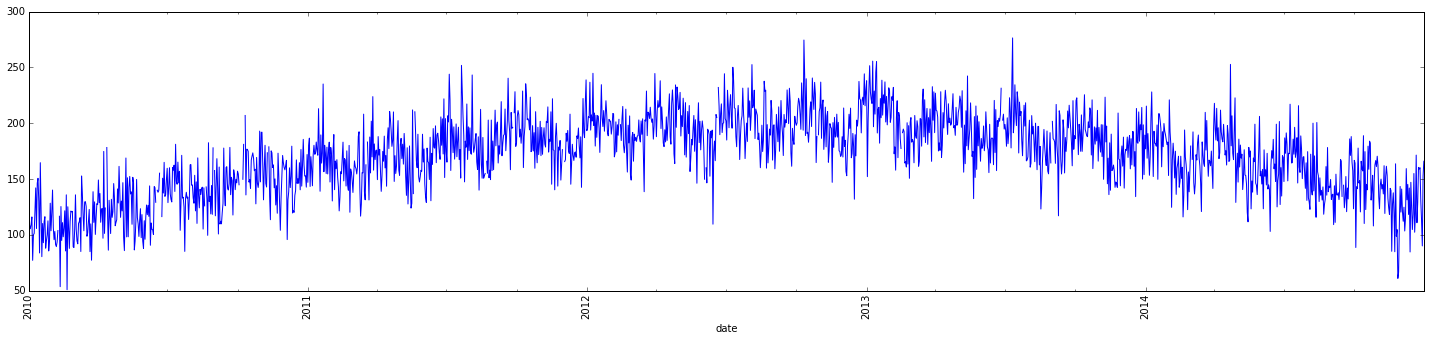

In [7]:
df['car.count'].plot(rot=90, figsize=(25, 5));

I'd guess that we have a linear combination of a quadratic, sinusoid and random stochastic signal.


### Single Year Analysis: first year in the record

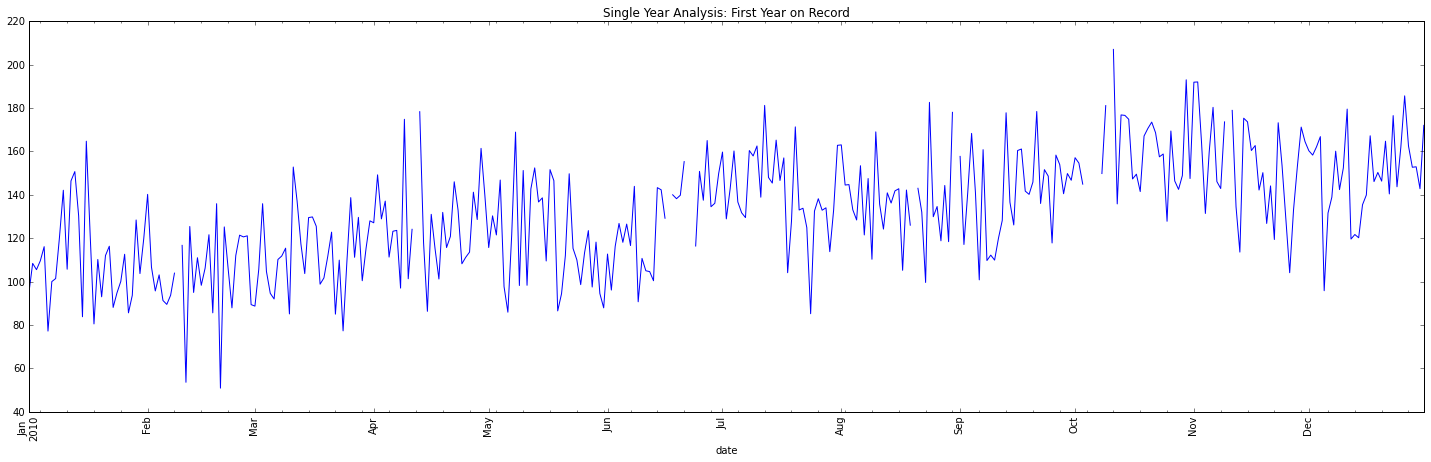

In [8]:
# year = df['car.count'][0:365]  if you are in a rush
year = df[df['date'] < pd.to_datetime('20110101')]['car.count']
year.plot(rot=90, figsize=(25, 7), title="Single Year Analysis: First Year on Record");

It's not easy to see, but there are missing values in the series. We need to treat those.

In [9]:
#TODO: add to signal processing module

def remove_nans(data, return_nan_index=False):
    nan_ind = np.nonzero(~np.isfinite(data))[0]
    good_data_ind = np.nonzero(np.isfinite(data))[0]
    good_data = data[good_data_ind]
          
    new_points = np.interp(nan_ind, good_data_ind, good_data)
    data[nan_ind] = new_points
    
    if return_nan_index:
        return data, nan_ind
    else:
        return data

In [10]:
year, nan_ind = remove_nans(year.copy(), return_nan_index=True)
year_linear_det = signal.detrend(year, axis=0, type='linear')

Single Year Linear Detrend Time Series

(0, 366)

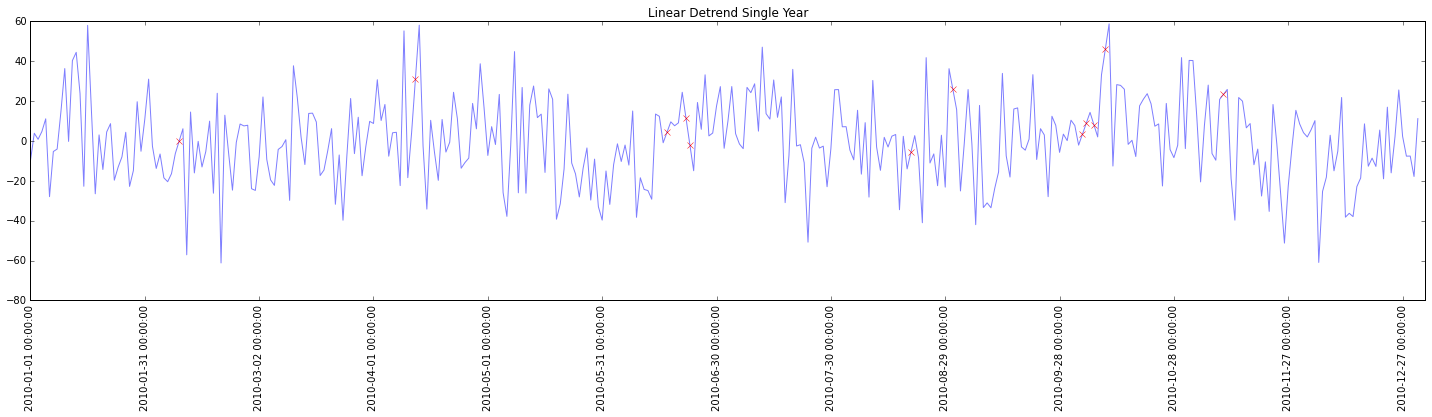

In [11]:
plt.figure(figsize=(25, 5))
plt.xticks(np.arange(year.shape[0])[0::30], year.index[0::30], rotation=90)
plt.plot(year_linear_det, alpha=0.5)
plt.title("Linear Detrend Single Year")
plt.plot(nan_ind, year_linear_det[nan_ind], 'rx')
plt.xlim(0, 366)

We see a $\approx$ 90 day period here.

Without more insight about the data we don't know if this is a nuisance or
a feature we are looking for.

The NaN replacements look reasonable.

## Group By for  Basic Analysis
Grouping the data points into bins and taking the mean, is very simialr to a Fourier Transform.

Pandas makes this easy and there's no reason not to. Especially if the data is related to business trends.

### Group by Month: Global monthly trend averaging over the 5 samples of each month

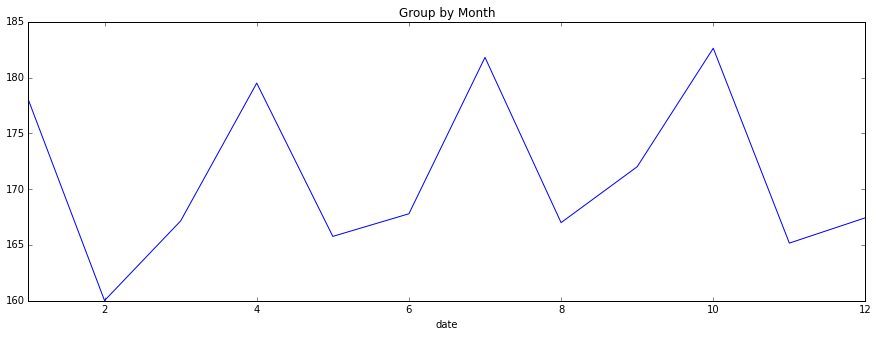

In [12]:
grp = df.groupby(df.date.map(lambda x:x.month))
grp.mean()['car.count'].plot(figsize=(15,5), title="Group by Month");

A group-by is sort of like a Fourier Transform where we choose just one frequency bin. There's the sinusodial period $\approx$ 90 days.

### Group by Day: Global day trend averaging over the 5 samples of each day

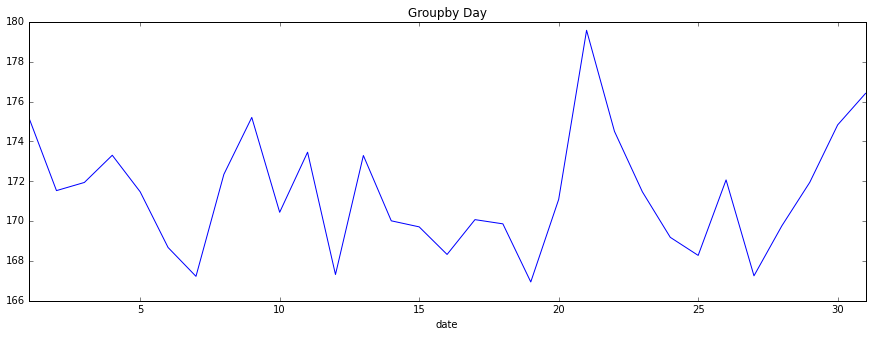

In [13]:
grp = df.groupby(df.date.map(lambda x:x.day))
grp.mean()['car.count'].plot(figsize=(15,5), title="Groupby Day");

It would appear as though the 21st day of each month saw greater count. However, we should check to see if it is statiscally significant. 

## Removing Confounds
### Quadratic Detrend Using PolyFit

In [14]:
poly =  np.polynomial.polynomial             
counts = remove_nans(df['car.count'].copy(), return_nan_index=False)

t = np.arange(df.shape[0])
coefs = poly.polyfit(t, counts, deg=2, full=False)
fit_curve = poly.polyval(t, coefs)

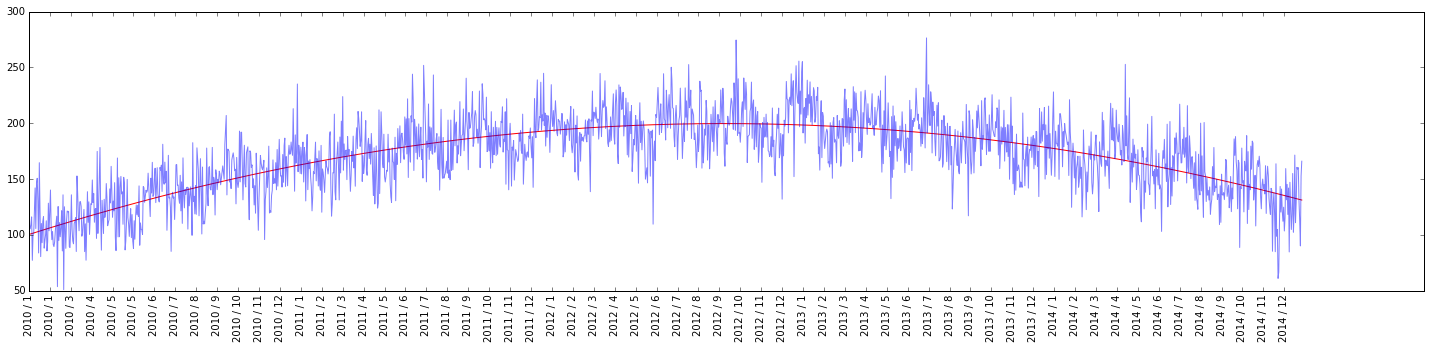

In [15]:
plt.figure(figsize=(25, 5))

plt.plot(fit_curve, 'r')
plt.plot(t, counts, alpha=0.5)

labels = df['date']
date_str = map(lambda x: str(x.year) + " / "  + str(x.month), labels)
plt.xticks(t[0::30], date_str[0::30], rotation="vertical");

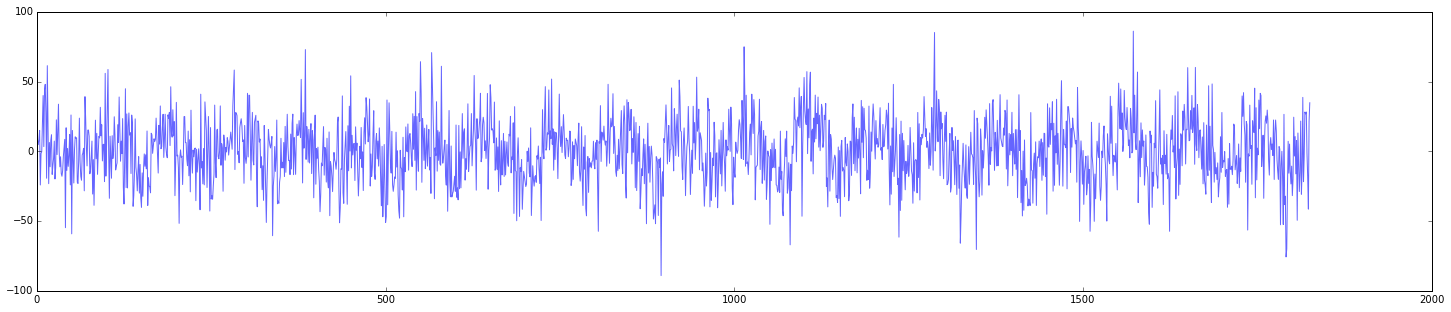

In [16]:
det_curve = counts - fit_curve
plt.figure(figsize=(25, 5))
plt.plot(det_curve, alpha=0.6);

## Further Confound Removal
Lets suppose that the quadratic is a measurement error and that the $\approx$ 90 day sinusodial is a well understood or nuisance, then we'll examine the remainder of the signal.

In [17]:
import sys
sys.path.append("/home/daniel/git/Python2.7/MRI/Modules")
import SignalProcessTools

sigtools = SignalProcessTools.SignalProcessTools()

### Frequency Domain Analysis Using FFT
I keep this method handy and it should be in my Sigtools Module. It's just as well that you can see inside the Welch call.

In [18]:
def fft(data):
        '''Plot FFT using Welch's method, daily resolution '''
        f, y = signal.welch(data, fs=1.0, nperseg=365, noverlap=None, nfft=512, scaling='spectrum', detrend="linear")
        
        interval = 3 # days
        periods = np.round(1./f[0::interval], 1)
        # clean up frequency of 0 Hz
        periods[0] = 0
        
        frqs = f[0::interval]
        plt.xticks(frqs, periods, rotation="vertical")
        
        plt.plot(f, y)
        
        plt.grid(True) 
        #plt.title("Welch FFT: Counts")
        plt.ylabel("Relative ratio of spectrum")
        plt.xlabel("Number of days in a period")
               
        return f, y, frqs

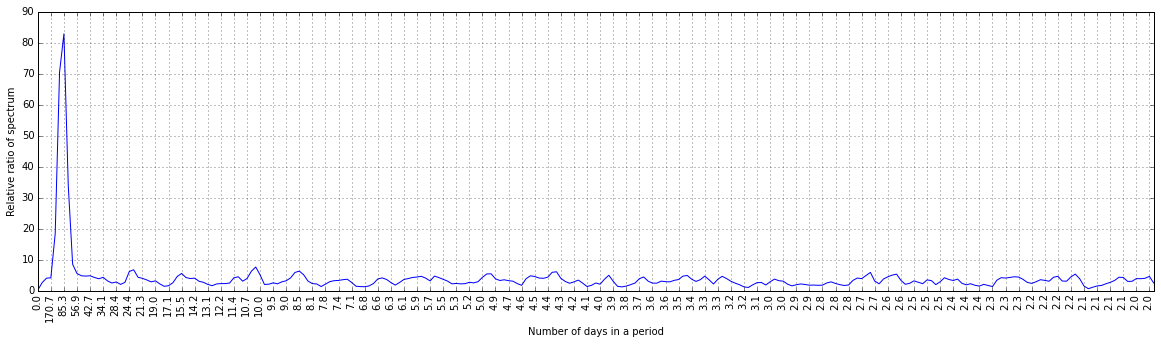

In [19]:
plt.figure(figsize=(20, 5))
f, y, frqs = fft(det_curve)

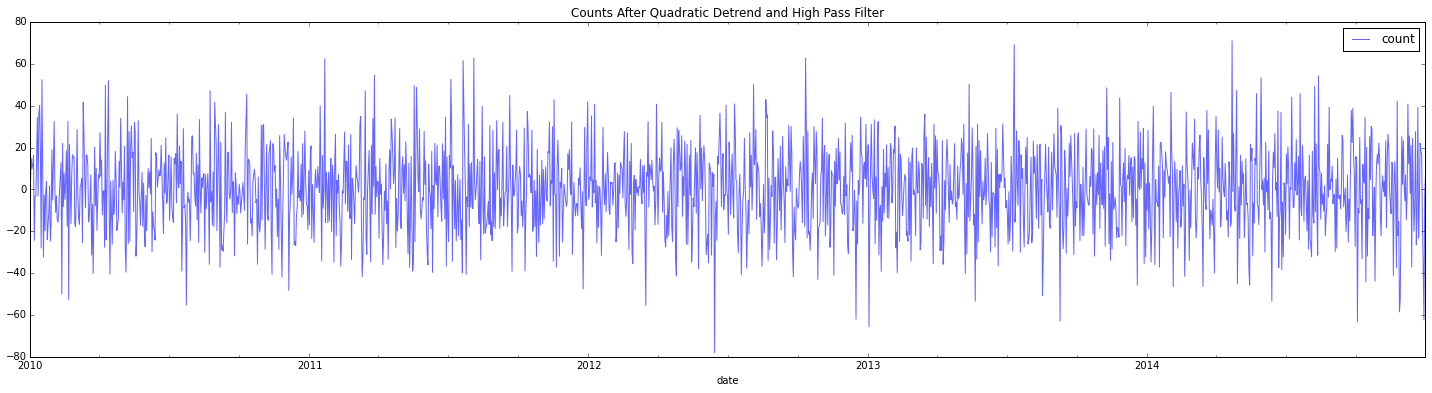

In [20]:
frq = 1 / 56.9 # from FFT output above
out = sigtools.hi_pass_filter(det_curve, frq, 1.0, 3)

dff = pd.DataFrame({'count':out}, index=df.index)
dff.plot(title="Counts After Quadratic Detrend and High Pass Filter", figsize=(25, 6), alpha=0.6)

## Fit A Distribution
The somewhat manual way and after with Seaborn

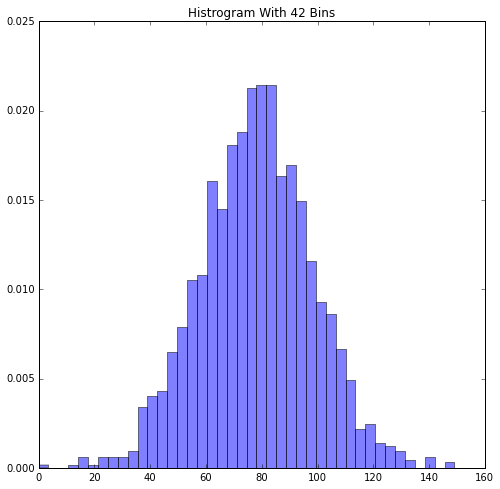

In [21]:
plt.figure(figsize=(8, 8))

# undo the centering that occures fromt he previous procesing
count = dff['count'] - dff['count'].min()

nbins = np.floor(np.sqrt(count.shape[0]))
y_counts, bin_x, patch = plt.hist(count, nbins, normed=True, alpha=0.5);
string = "Histrogram With %s Bins" % str(int(nbins))
plt.title(string)

Perhaps a Gausian

In [22]:
bin_x = bin_x[1:]# drop the first bin to match the array lengths

In [23]:
from scipy.optimize import curve_fit

def gauss(x, *p):
    A, mu, sig = p
    gau = A * np.exp(-(x-mu)**2 / (2 * sig)**2)
    return gau

In [24]:
coeff, var_matrix = curve_fit(gauss, bin_x, y_counts, p0=[0.001, 0.0001, 20.0])
print "Amplitude:%f  mean:%f   std:%f" %(coeff[0], coeff[1], coeff[2])

Amplitude:0.020397  mean:79.954072   std:13.724083


<Container object of 42 artists>

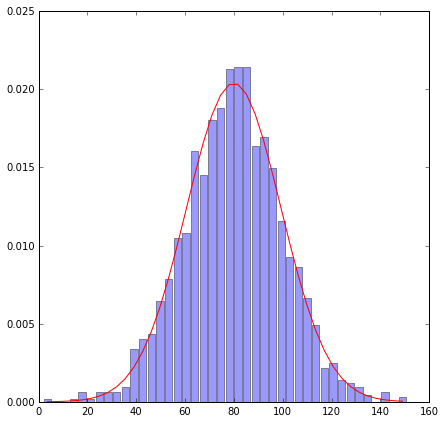

In [25]:
fit_gau = gauss(bin_x, *coeff)
plt.figure(figsize=(7, 7))

plt.plot(bin_x, fit_gau, 'r')
plt.bar(bin_x, y_counts, alpha=0.4, width=3, align='center')

## Jackknife Bias Estimation

Since the time dependant trends have been removed, the remaining records should be idenpendent. 

We are putting a lot of weight ont he Guassian fit above. That mean and standard deviation are the main metrics that describe the data. To find out if our
method of computing the mean and sigma are biased, we can use a resampling technique. The most simple is the Jackknife.

In [26]:
def jk_gau_fit(sample):
    nbins = np.floor(np.sqrt(sample.shape[0]))
    y_counts, bin_x = np.histogram(sample, nbins, normed=True); # slightly different method is faster as there is no plotting
    bin_x = bin_x[1:]
    coeff, var_matrix = curve_fit(gauss, bin_x, y_counts, p0=[0.001, 0.0001, 20.0])

    return coeff[1], coeff[2] # amp, mean, sig

In [27]:
def jk_params(data):
    sig = np.zeros_like(data)
    mu = np.zeros_like(data)
    n = data.shape[0]
    for i in range(n):
        sample = np.delete(data, i)
        mu[i], sig[i] = jk_gau_fit(sample)
        
    return mu, sig  

In [28]:
count = np.array(count) # cast from dataframe into numpy array
jkmu, jksig = jk_params(count)

In [29]:
# 64 bit floats have 32 sig figs
print "Original Fit STD:   %.4f"  %coeff[2]
print "Mean Sample  STD:   %.4f\n"  %jksig.mean()

sig_bias =  coeff[2]- jksig.mean() 
print "Difference:         %07.4f" %(sig_bias)

Original Fit STD:   13.7241
Mean Sample  STD:   13.3935

Difference:         00.3305


In [32]:
# 64 bit floats have 32 sig figs
print "Original Fit :   %.4f"  %coeff[1]
print "Mean Sample  :   %.4f\n"  %jkmu.mean()

mu_bias =  coeff[1]- jkmu.mean() 
print "Difference:      %07.4f" %(mu_bias)

Original Fit :   79.9541
Mean Sample  :   79.9539

Difference:      00.0001


Not surprised that the mean has little bias.

In [36]:
sig = coeff[2] - sig_bias

print "mu:%.1f  sig:%.1f" %(mu, sig) # rounding to three sig figs.

mu:80.0  sig:13.4


## Mean Revisted
The mean of the count taken to 3 sig figs (decided arbitraily since I don't have details of the data collection).
$$\mu = 80.0 \pm 13.4$$